# 机器学习算法实例

> ## 案例说明    
> - 利用3KeyMaster仿真机模拟下泄管道破裂事故（LD）、回路冷却剂管道冷管段破口（LOCA）、稳压器泄压阀误开事故（PORV）、蒸汽发生器传热管道破裂事故（SGTR）事故，用机器学习模型对事故发生的位置（即`事故类型`）和`事故严重程度`进行预测。    
> - `事故严重程度`选取100%破口、50%破口、20%破口、10%破口，与`事故类型`组合出16个`事故序列`进行预测。   
> - 每个`事故序列`的样本数量如下：
|事故严重程度|100%|50%|20%|10%|
|---|---|---|---|---|
|LD|401|406|406|409|
|LOCA|96|405|540|402|
|PORV|401|406|406|412|
|SGTR|401|406|406|407|
> -每个样本选择电厂运行中的31个特征参数。特征名称已封装到`class Data`中的`parameter_names`中。
> -本案例忽略参数搜索算法，如在线性模型中的`梯度下降算法`。






In [2]:
import os
import openpyxl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [3]:
#一些前置的函数
#用于纵向排布的数据获取
def getParameter1(sheet, amount):
    a = []
    b = []
    for i in range(1, amount + 1):
        for ii in range(1, 33):
            b.append(sheet.cell(row=ii, column=i).value)
        a.append(b)
        b = []
    array = np.array(a)
    return array

#用于横向排布的数据获取
def getParameter2(sheet, amount):
    a = []
    b = []
    for i in range(1, amount + 1):
        for ii in range(1, 33):
            b.append(sheet.cell(row=i, column=ii).value)
        a.append(b)
        b = []
    array = np.array(a)
    return array

#用于特殊排布的数据获取
def getParameter3(sheet, amount):
    a = []
    b = []
    for i in range(1, amount + 1):
        for ii in range(1, 18): #第1列到第18列的参数
            b.append(sheet.cell(row=i, column=ii).value)
        for ii in range(23, 25):#第23列到25列的参数，以此类推
            b.append(sheet.cell(row=i, column=ii).value)
        for ii in range(26, 28):
            b.append(sheet.cell(row=i, column=ii).value)
        b.append(sheet.cell(row=i, column=32).value)
        b.append(sheet.cell(row=i, column=41).value)
        for ii in range(43, 45):
            b.append(sheet.cell(row=i, column=ii).value)
        for ii in range(48, 51):
            b.append(sheet.cell(row=i, column=ii).value)
        b.append(sheet.cell(row=i, column=58).value)
        for ii in range(64, 67):
            b.append(sheet.cell(row=i, column=ii).value)
        a.append(b)
        b = []
    array = np.array(a)
    return array

def create_target(data, num, n, flag, Class):
    if (flag=='BP'):
        target_list = [[0, 0, 0, 0],
                       [1, 0, 0, 0],
                       [0, 1, 0, 0],
                       [0, 0, 1, 0],
                       [0, 0, 0, 1]]
    elif(flag=='SVC'):
        target_list = [0, 1, 2, 3, 4]
        
    L = []
    
    if (flag=='RF'):
        target_list = [[0, 0, 0, 0],
                       [1, 0, 0, 0],
                       [0, 1, 0, 0],
                       [0, 0, 1, 0],
                       [0, 0, 0, 1]]
        target_name = ['LD', 'LOCA', 'PORV', 'SGTR']
        for i in range(n):
            L.append(target_list[0])
        for i in range(n, len(data)):
            L.append(target_list[target_name.index(Class)+1])
        a = np.array(L)
    else:
        for i in range(n):
            L.append(target_list[0])
        for i in range(n, len(data)):
            L.append(target_list[num+1])
        a = np.array(L)
    return a


![alt='datset'](img/dataset.png)

In [4]:
class Data:
    def __init__(self, name):
        wb3 = openpyxl.load_workbook("EXPERIMENT DATA3.xlsx")
        LD100_sheet = wb3['LD100']
        LOCA100_sheet = wb3['LOCA100']
        PORV100_sheet = wb3['PORV100']
        SGTR100_sheet = wb3['SGTR100']
        NORMAL_sheet = wb3['NORMAL']
        LD50_sheet = wb3['LD50']
        LD20_sheet = wb3['LD20']
        LD10_sheet = wb3['LD10']
        LOCA50_sheet = wb3['LOCA50']
        LOCA20_sheet = wb3['LOCA20']
        LOCA10_sheet = wb3['LOCA10']
        PORV50_sheet = wb3['PORV50']
        PORV20_sheet = wb3['PORV20']
        PORV10_sheet = wb3['PORV10']
        SGTR50_sheet = wb3['SGTR50']
        SGTR20_sheet = wb3['SGTR20']
        SGTR10_sheet = wb3['SGTR10']
        LD100 = getParameter1(LD100_sheet, 401)
        LOCA100 = getParameter1(LOCA100_sheet, 96)
        PORV100 = getParameter1(PORV100_sheet, 401)
        SGTR100 = getParameter1(SGTR100_sheet, 401)
        NORMAL = getParameter1(NORMAL_sheet, 401)
        LD50 = getParameter3(LD50_sheet, 405)
        LD20 = getParameter3(LD20_sheet, 406)
        LD10 = getParameter3(LD10_sheet, 409)
        LOCA50 = getParameter3(LOCA50_sheet, 405)
        LOCA20 = getParameter3(LOCA20_sheet, 540)
        LOCA10 = getParameter3(LOCA10_sheet, 402)
        PORV50 = getParameter3(PORV50_sheet, 406)
        PORV20 = getParameter3(PORV20_sheet, 406)
        PORV10 = getParameter3(PORV10_sheet, 412)
        SGTR50 = getParameter3(SGTR50_sheet, 406)
        SGTR20 = getParameter3(SGTR20_sheet, 406)
        SGTR10 = getParameter3(SGTR10_sheet, 407)
        
        data_LD = np.vstack((LD100, LD50, LD20, LD10))
        data_LOCA = np.vstack((LOCA100, LOCA50, LOCA20, LOCA10))
        data_PORV = np.vstack((PORV100, PORV50, PORV20, PORV10))
        data_SGTR = np.vstack((SGTR100, SGTR50, SGTR20, SGTR10))
        
        self.dataset = np.vstack((data_LD, data_LOCA, data_PORV, data_SGTR))
        data_list = {'LD100':LD100, 'LD50':LD50, 'LD20':LD20, 'LD10':LD10, 
                     'LOCA100':LOCA100, 'LOCA50':LOCA50, 'LOCA20':LOCA20, 'LOCA10':LOCA10,
                     'PORV100':PORV100, 'PORV50':PORV50, 'PORV20':PORV20, 'PORV10':PORV10,
                     'SGTR100':SGTR100, 'SGTR50':SGTR50, 'SGTR20':SGTR20, 'SGTR10':SGTR10}
        
        self.data_names = list(data_list.keys())
        self.class_names = ['LD', 'LOCA', 'PORV', 'SGTR']
        
        LD100_target = create_target(LD100, 0, 22, name, 'LD')
        LD50_target = create_target(LD50, 1, 5, name, 'LD')
        LD20_target = create_target(LD20, 2, 5, name, 'LD')
        LD10_target = create_target(LD10, 3, 5, name, 'LD')
        
        LOCA100_target = create_target(LOCA100, 0, 19, name, 'LOCA')
        LOCA50_target = create_target(LOCA50, 1, 5, name, 'LOCA')
        LOCA20_target = create_target(LOCA20, 2, 5, name, 'LOCA')
        LOCA10_target = create_target(LOCA10, 3, 5, name, 'LOCA')
        
        PORV100_target = create_target(PORV100, 0, 34, name, 'PORV')
        PORV50_target = create_target(PORV50, 1, 5, name, 'PORV')
        PORV20_target = create_target(PORV20, 2, 5, name, 'PORV')
        PORV10_target = create_target(PORV10, 3, 5, name, 'PORV')
        
        SGTR100_target = create_target(SGTR100, 0, 18, name, 'SGTR')
        SGTR50_target = create_target(SGTR50, 1, 5, name, 'SGTR')
        SGTR20_target = create_target(SGTR20, 2, 5, name, 'SGTR')
        SGTR10_target = create_target(SGTR10, 3, 5, name, 'SGTR')
        
        if (name == 'BP' or name == 'RF'):
            self.targetset = np.vstack((LD100_target, LD50_target, LD20_target, LD10_target,
                                        LOCA100_target, LOCA50_target, LOCA20_target, LOCA10_target,
                                        PORV100_target, PORV50_target, PORV20_target, PORV10_target,
                                        SGTR100_target, SGTR50_target, SGTR20_target, SGTR10_target))
        elif (name == 'SVC'):
            self.targetset = np.hstack((LD100_target, LD50_target, LD20_target, LD10_target,
                                        LOCA100_target, LOCA50_target, LOCA20_target, LOCA10_target,
                                        PORV100_target, PORV50_target, PORV20_target, PORV10_target,
                                        SGTR100_target, SGTR50_target, SGTR20_target, SGTR10_target))
            
        self.search = [0]
        for i in range(1, 17):
            self.search.append(0)
            self.search[i] = self.search[i-1] + len(list(data_list.values())[i-1])
        
        
        self.parameter_names = []
        para_sheet = wb3['PARAMETER']
        for i in range(1, 33):
            value = para_sheet.cell(row=i, column=1).value
            self.parameter_names.append(value)
        
        if (name == 'BP'):
            self.Delete_time()
            self.Preprocessing_for_BP
        
        self.keys = ['dataset', 'targetset', 'search', 'data_names', 'class_names', 
                     'parameter_names']
    
    def get_array(self, name):
        index = self.data_names.index(name)
        return (self.dataset[self.search[index]:self.search[index+1]], 
               self.targetset [self.search[index]:self.search[index+1]])
    
    def get_class(self, name):
        index = self.class_names.index(name)
        start = index * 4
        end = (index + 1) * 4 
        return (self.dataset[self.search[start]:self.search[end]],
               self.targetset [self.search[start]:self.search[end]])
    
    def Preprocessing_for_BP(self):
        mean = self.dataset.mean(axis=0)
        std = self.dataset.std(axis=0)
        self.dataset = (self.dataset-mean)/std
        for i in range(len(self.dataset)):
            for ii in range(len(self.dataset[i])):
                if (np.isnan(self.dataset[i][ii])):
                    self.dataset[i, ii] = 0
                    
    def Preprocessing_for_SVC(self):
        max_val = self.dataset.max(axis=0)
        min_val = self.dataset.min(axis=0)
        distance = max_val - min_val
        self.dataset = (self.dataset - min_val)/distance
        for i in range(len(self.dataset)):
            for ii in range(len(self.dataset[i])):
                if (np.isnan(self.dataset[i][ii])):
                    self.dataset[i, ii] = 0
            
                    
    def Delete_time(self):
        self.dataset = np.delete(self.dataset, [0], axis=1)
        


## 随机森林

> ### 决策树模型
> - CART决策树生成判断条件的方法：   
    > ![alit='Gini'](img/Gini.png)    
> - 决策树模型如下：
    > ![alt='decition_tree'](img/decision_tree.png)
> - 随机森林由多棵决策树构成。每棵决策树会采用`自助取样`的方法有放回地抽取相同数量的样本，并且每棵决策树只选取`部分的`且`不同的`样本参数传入模型学习。
> -target为多标签时，会平均计算各个标签的值，取数值最大的标签作为输出。    
例如，三棵决策树，且问题为3分类问题时，假设三棵决策树的输出分别为`[1, 0, 0]`、`[1, 0, 0]`、 `[0, 1, 0]`，则随机森林输出为`[0.6667, 0.3333, 0]`，最终输出为`[1, 0, 0]`

> ### 训练方法
> 运用随机森林模型预测`事故类型`。分别选取16个`事故序列`中75%的样本作为`训练集`传入`随机森林`学习，选取剩余的25%的样本作为`测试集`对模型的学习效果进行检验。

In [5]:
#生成数据集
data_RF = Data('RF')
data_RF.Delete_time()

In [6]:
#展示数据集内容
data_RF.keys

['dataset',
 'targetset',
 'search',
 'data_names',
 'class_names',
 'parameter_names']

In [7]:
#设置决策森林
def Set_RF(estimator, random, feature, depth):
    return RandomForestClassifier(n_estimators=estimator, random_state=random, max_features=feature, max_depth=depth)

#测试函数
def Test_RF(RF, data_type, random):
    LD_array, LD_target = data_type.get_class('LD')
    LOCA_array, LOCA_target = data_type.get_class('LOCA')
    PORV_array, PORV_target = data_type.get_class('PORV')
    SGTR_array, SGTR_target = data_type.get_class('SGTR')
    
    #利用train_test_split生成训练集、测试集
    X_train_LD, X_test_LD, y_train_LD, y_test_LD = train_test_split(LD_array, LD_target, stratify=LD_target,
                                                        shuffle=True, random_state=random)
    X_train_LOCA, X_test_LOCA, y_train_LOCA, y_test_LOCA = train_test_split(LOCA_array, LOCA_target, stratify=LOCA_target,
                                                        shuffle=True, random_state=random)
    X_train_PORV, X_test_PORV, y_train_PORV, y_test_PORV = train_test_split(PORV_array, PORV_target, stratify=PORV_target,
                                                        shuffle=True, random_state=random)
    X_train_SGTR, X_test_SGTR, y_train_SGTR, y_test_SGTR = train_test_split(SGTR_array, SGTR_target, stratify=SGTR_target,
                                                        shuffle=True, random_state=random)
    X_train = np.vstack((X_train_LD, X_train_LOCA, X_train_PORV, X_train_SGTR))
    y_train = np.vstack((y_train_LD, y_train_LOCA, y_train_PORV, y_train_SGTR))
    
    #训练模型并预测结果
    RF.fit(X_train, y_train)
    prediction_LD = RF.predict(X_test_LD)
    prediction_LOCA = RF.predict(X_test_LOCA)
    prediction_PORV = RF.predict(X_test_PORV)
    prediction_SGTR = RF.predict(X_test_SGTR)
    score_LD = RF.score(X_test_LD, y_test_LD)
    score_LOCA = RF.score(X_test_LOCA, y_test_LOCA)
    score_PORV = RF.score(X_test_PORV, y_test_PORV)
    score_SGTR = RF.score(X_test_SGTR, y_test_SGTR)
    print('Score LD:{}'.format(score_LD))
    print('Score LOCA:{}'.format(score_LOCA))
    print('Score PORV:{}'.format(score_PORV))
    print('Score SGTR:{}'.format(score_SGTR))

RF = Set_RF(15, 0, 20, 10)
Test_RF(RF, data_RF, 0)

Score LD:0.9975369458128078
Score LOCA:1.0
Score PORV:1.0
Score SGTR:1.0


> ### 学习完成的某棵决策树
![alt='RF1'](img/RF1.png)

> ### 输出参数重要程度

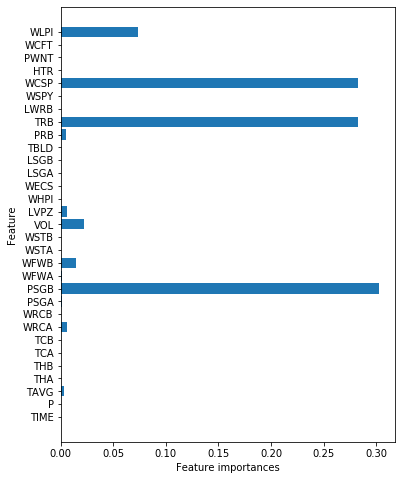

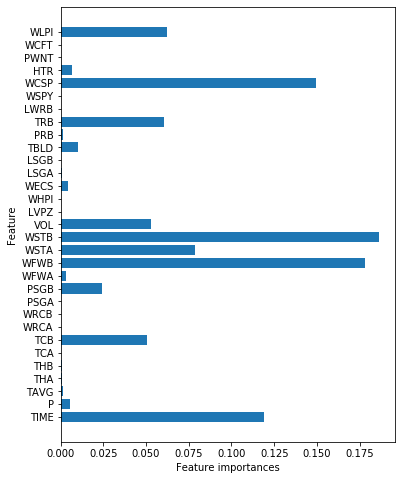

In [7]:
#随机森林属性 RF.feature_importances_
def plot_feature_importances(model, title):
    plt.figure(figsize=(6, 8))
    plt.barh(range(31), model.feature_importances_, align='center')
    plt.yticks(np.arange(31), title)
    plt.xlabel('Feature importances')
    plt.ylabel('Feature')
    plt.show
     
plot_feature_importances(RF[0], data_RF.parameter_names) 
plot_feature_importances(RF, data_RF.parameter_names)

## BP神经网络

> - ### 多层感知机模型
    > ![alt='MLP](img/MLP.png)
> - ### 神经元   
    > 输入：线性加和    
    > 输出：激活函数——双曲正切函数    
    ![alt='Nerve'](img/nerve.png)
    ![alt='tanh'](img/tanh.png)
> - ### 调参
    > `alpha`：影响正则化对模型线性部分的影响。与正则化程度成反比，与模型复杂程度成正比。    
    > `hidden_layer_sizes`：模型神经元层数以及各层神经元个数，与模型复杂程度成正比。
> - ### 预处理    
    > 所有数据进行标准化处理。处理后样本集的方差为1，均值为0。    
    > ![alt='Preprocessing1'](img/Preprocessing1.png)

> ### 训练方法    
运用MLP预测`事故严重程度`。建立4个MLP模型，分别传入4种`事故类型`数据样本的75%作为4个模型的`训练集`，剩余25%作为`测试集`测试模型精度。

In [8]:
#生成数据集
data_BP = Data('BP')
data_BP.Delete_time()
data_BP.Preprocessing_for_BP()

In [9]:
#设置BP网络
def Set_BP(layer, random):
    return MLPClassifier(solver='lbfgs', activation='tanh', random_state=random,
                         hidden_layer_sizes=layer, alpha=1, max_iter=3000)

#测试BP网络
def Test_BP(BP, data, target, random):
    X_train, X_test, y_train, y_test = train_test_split(data, target, stratify=target,
                                                        shuffle=True, random_state=random)
    BP.fit(X_train, y_train)
    prediction = BP.predict(X_test)
    score = BP.score(X_test, y_test)
    print('Score:{}'.format(score))
    return score, prediction

LD_BP = Set_BP([100], 0)
LOCA_BP = Set_BP([100], 0)
PORV_BP = Set_BP([100], 0)
SGTR_BP = Set_BP([100], 0)

LD_array, LD_target = data_BP.get_class('LD')
LOCA_array, LOCA_target = data_BP.get_class('LOCA')
PORV_array, PORV_target = data_BP.get_class('PORV')
SGTR_array, SGTR_target = data_BP.get_class('SGTR')

Test_BP(LD_BP, LD_array, LD_target, 0)
Test_BP(LOCA_BP, LOCA_array, LOCA_target, 0)
Test_BP(PORV_BP, PORV_array, PORV_target, 0)
Test_BP(SGTR_BP, SGTR_array, SGTR_target, 0)

Score:0.9482758620689655
Score:0.9695290858725761
Score:0.9287469287469288
Score:0.9629629629629629


(0.9629629629629629,
 array([[0, 0, 1, 0],
        [0, 0, 0, 1],
        [1, 0, 0, 0],
        ...,
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [1, 0, 0, 0]]))

##### 随参数的变化敏感，调参复杂，但学习上限很高    
![alt='PORV_BP'](img/PORV_BP.png)

## RBF核SVC

> - ### 模型基本原理
    > 模型训练的过程中，在训练集中寻找合适的样本点作为`支持向量`。预测时计算样本点到`支持向量`的距离，以此为依据判断`测试集`样本点的类型。
> - ### 高斯核（RBF）半径
    > 计算样本点到支持向量的一种方式。
> - ### 调参
    > `C`:正则化对模型决策边界的影响。与正则化程度成反比，与模型复杂程度成正比。    
    > `gamma`:高斯核半径的距离。与高斯核半径成反比，与模型复杂程度成正比。
> - ### 预处理
    > 所有数据量纲统一化，转化为某个特征的百分比。    
    > ![alt='Preprocessing2'](img/Preprocessing2.png)

> ### 训练方法
    > 与BP神经网络相同。

In [10]:
#生成数据集
data_SVC = Data('SVC')
data_SVC.Delete_time()
data_SVC.Preprocessing_for_SVC()

In [11]:
#生成SVC模型
def Set_SVC(C_para, gamma_para):
    return SVC(kernel='rbf', C=C_para, gamma=gamma_para)

#测试SVC
def Test_SVC(SVC, data, target, random):
    X_train, X_test, y_train, y_test = train_test_split(data, target, stratify=target,
                                                        shuffle=True, random_state=random)
    SVC.fit(X_train, y_train)
    prediction = SVC.predict(X_test)
    score = SVC.score(X_test, y_test)
    print('Score:{}'.format(score))
    return score, prediction

LD_SVC = Set_SVC(500, 5)
LOCA_SVC = Set_SVC(400, 10)
PORV_SVC = Set_SVC(200, 12)
SGTR_SVC = Set_SVC(200, 10)

LD_array2, LD_target2 = data_SVC.get_class('LD')
LOCA_array2, LOCA_target2 = data_SVC.get_class('LOCA')
PORV_array2, PORV_target2 = data_SVC.get_class('PORV')
SGTR_array2, SGTR_target2 = data_SVC.get_class('SGTR')

Test_SVC(LD_SVC, LD_array2, LD_target2, 0)
Test_SVC(LOCA_SVC, LOCA_array2, LOCA_target2, 0)
Test_SVC(PORV_SVC, PORV_array2, PORV_target2, 0)
Test_SVC(SGTR_SVC, SGTR_array2, SGTR_target2, 0)

Score:0.9778325123152709
Score:0.9944598337950139
Score:0.9877149877149877
Score:1.0


(1.0,
 array([4, 1, 3, 3, 1, 2, 3, 4, 3, 3, 3, 3, 1, 2, 4, 2, 4, 1, 1, 1, 2, 2,
        1, 2, 1, 4, 1, 1, 1, 2, 2, 2, 3, 1, 3, 4, 3, 3, 3, 1, 1, 1, 1, 1,
        4, 4, 3, 1, 1, 3, 4, 3, 2, 3, 1, 1, 4, 1, 4, 4, 2, 2, 4, 4, 1, 1,
        2, 4, 4, 4, 2, 1, 4, 2, 1, 2, 2, 3, 3, 3, 1, 4, 4, 2, 4, 3, 3, 4,
        2, 3, 2, 1, 4, 4, 3, 4, 3, 3, 1, 3, 4, 1, 1, 4, 1, 4, 4, 4, 4, 1,
        1, 4, 4, 3, 1, 1, 2, 1, 3, 2, 2, 0, 4, 1, 4, 3, 2, 4, 3, 4, 1, 4,
        1, 4, 2, 2, 3, 2, 1, 3, 3, 3, 4, 1, 2, 2, 2, 2, 4, 4, 2, 4, 3, 2,
        2, 2, 3, 4, 0, 2, 4, 3, 4, 2, 3, 1, 2, 3, 2, 3, 3, 4, 4, 4, 2, 4,
        3, 3, 2, 1, 2, 4, 3, 4, 2, 3, 3, 1, 2, 2, 1, 2, 4, 2, 2, 1, 4, 1,
        0, 1, 3, 2, 1, 3, 3, 4, 1, 0, 3, 4, 1, 2, 4, 1, 2, 2, 2, 3, 3, 2,
        1, 1, 1, 1, 1, 4, 3, 2, 2, 2, 3, 2, 4, 4, 2, 3, 3, 4, 1, 1, 1, 1,
        2, 3, 3, 1, 2, 1, 2, 2, 3, 2, 2, 3, 0, 4, 3, 4, 3, 1, 4, 3, 3, 4,
        1, 3, 4, 4, 4, 4, 4, 2, 4, 3, 4, 1, 4, 1, 1, 1, 3, 4, 4, 1, 1, 3,
        2, 2, 4, 1, 2, 2, 1, 1, 

![alt='PORV_RBFSVC'](img/PORV_RBFSVC.png)

> ## 总结
    > - 模型的选择与调参的设定应该根据样本集的具体特征和应用场景而定。
    > > - 确保识别精度高的情况下识别速度尽可能快————最理想的情况下使用线性模型进行判断    
    > > - 不同事故类型的样本点之间界线分明，可使用较为简单的线性模型
    > > - 相同事故不同严重程度的样本点之间界限不是非常明确，故应牺牲一些模型简化程度（识别精度与识别速度），用复杂的非线性模型进行判断
    > - 模型可解释性排名：随机森林、SVC、BP神经网络
    > > 模型的可解释性影响了模型进一步修改参数的难度
    > - 模型的求解算法会略微影响模型的复杂程度和模型的预测效果。根据具体情况可留意一下

> ## 参考
> sklearn官方文档：<https://scikit-learn.org/stable/index.html>    
> 本次讲演的所有文档：<https://github.com/chunsen314/python_learning.git>